## Comparing Agents List:

###### 1. Single Action Agent
Always returns the same action / product id.

###### 2. Random Action Agent
The Agent returns the random action from all of product id's range.

###### 3. Organic Product Count Agent
The Agent that selects an action based on the most frequently viewed Product.

###### 4. Organic Per User Count Agent
The Agent that counts organic views of products per a user and selects an action for the most frequently shown product.

###### 5. Define Organic MF Agent
The Agent that selects an action from the model that performs Organic Events matrix factorisation.

###### 6. Bandit Click Count Agent
The Agent that selects an Action for the most frequently clicked bandit action before.

###### 7. Bandit MF Agent - used Matrix Factorization learning model
The Agent chooses maximum logit (logistic regression) from all possible actions.

###### 8. Likelihood Agent
 - train:
    1. take offline logs where bandit click is random
            t   	u 	z           v   a    	c 	    ps   	ps-a
        0 	0.0 	0 	organic 	6 	<NA> 	NaN 	NaN 	None
        1 	1.0 	0 	organic 	7 	<NA> 	NaN 	NaN 	None
        2 	2.0 	0 	organic 	15 	<NA> 	NaN 	NaN 	None
        3 	3.0 	0 	organic 	2 	<NA> 	NaN 	NaN 	None
        4 	4.0 	0 	bandit 	   <NA> 38 	    1.0 	0.025 	()
        5 	5.0 	0 	bandit 	   <NA> 34 	    0.0 	0.025

    2. build_train_data() -> run f_provider.observe -> user_states, actions, rewards, proba_actions

    3. create features matrix - a matrix of views by products
    
    4. creates LogisticRegression model
    
    5. do model.fit (features, rewards)

 - act:
    1. do score_products -> model.predict_proba()
    2. choose max probability


Act method returns an action based on current observation and past history.


## Environment Setup

In [1]:
from copy import deepcopy

import recogym
from my_agent_utils import add_agent_id, combine_stat
from my_entries.likehood_agent import LikelihoodAgent, CountFeatureProvider
from single_action_agent import SingleActionAgent
%matplotlib inline
import gym
import matplotlib.pyplot as plt

from recogym import env_1_args, Configuration
from recogym.agents import OrganicUserEventCounterAgent, organic_user_count_args, OrganicCount, organic_count_args, \
    OrganicMFSquare, organic_mf_square_args, BanditCount, bandit_count_args, BanditMFSquare, bandit_mf_square_args
from recogym.agents import RandomAgent, random_args
from recogym.evaluate_agent import plot_verify_agents, verify_agents

# Set style for pretty plots
plt.style.use('ggplot')

products = 40

offline_users = 16000
online_users = 200

# You can overwrite environment arguments here:

env_1_args['random_seed'] = 42
env_1_args['num_products']= products
env_1_args['phi_var']=0.0
env_1_args['number_of_flips']=1

# env_1_args['sigma_mu_organic'] = 0.0
# env_1_args['sigma_omega']=0
# env_1_args['normalize_beta']=True

# Initialize the gym for the first time by calling .make() and .init_gym()

#---------------------------------------------
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 3]

env_1_args['number_of_flips'] = 0
env_1_args['sigma_mu_organic'] = 0.0
env_1_args['sigma_omega'] = 1
env_1_args['random_seed'] = 42
env_1_args['num_products'] = products
env_1_args['K'] = 5
env_1_args['number_of_flips'] = 5
#---------------------------------------------

env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

env.reset()


/workspace/ML/reco-gym/recogym/envs/abstract.py:54: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


1. Define Single Action Agent

In [2]:
single_action_agent = SingleActionAgent(Configuration({**env_1_args,}))

SingleActionAgent %%%% num_products: 40


2. Define Random Action Agent

In [3]:
random_agent = RandomAgent(Configuration({**random_args,**env_1_args,}))

RandomAgent %%%% num_products: 40


3. Define Organic Product Count Agent

In [4]:
organic_count_agent = OrganicCount(Configuration({**organic_count_args,**env_1_args,}))

4. Define Organic Per User Count Agent

In [5]:
organic_user_counter_agent = OrganicUserEventCounterAgent(Configuration({**organic_user_count_args, **env_1_args, 'select_randomly': True,}))

5. Define Organic MF Agent

In [6]:
organic_mf_agent = OrganicMFSquare(Configuration({**organic_mf_square_args, **env_1_args, 'select_randomly': True,}))

6. Define Bandit Click Count Agent

In [7]:
bandit_count_agent = BanditCount(Configuration({**bandit_count_args,**env_1_args,}))

BanditCount %%%% num_products: 40


7. Define Bandit MF Agent

In [8]:
bandit_mf_square_agent = BanditMFSquare(Configuration({ **bandit_mf_square_args, **env_1_args,}))

8. Define Likelihood Agent

In [9]:
from scipy.stats import beta
import pandas as pd

config = Configuration(env_1_args)

count_product_views_feature_provider = CountFeatureProvider(config)  # <----- CountFeatureProvider

likelihood_agent = LikelihoodAgent(count_product_views_feature_provider)

lh_log_data = deepcopy(env).generate_logs(offline_users)

likelihood_agent.train(lh_log_data)

bandits = lh_log_data[lh_log_data['z'] == 'bandit']
successes = bandits[bandits['c'] == 1].shape[0]
failures = bandits[bandits['c'] == 0].shape[0]

lh_agent_res = add_agent_id(
    'Likelihood',
    beta.ppf(0.025, successes + 1, failures + 1),
    beta.ppf(0.500, successes + 1, failures + 1),
    beta.ppf(0.975, successes + 1, failures + 1))


Organic Users: 0it [00:00, ?it/s]
Users:   0%|          | 0/16000 [00:00<?, ?it/s]

# ------------------------------------------------------------------------------------
#  GENERATE LOGS FOR AGENT None
# ------------------------------------------------------------------------------------


Users: 100%|██████████| 16000/16000 [04:27<00:00, 59.72it/s]



LikelihoodAgent train() num_products 40

run model.fit rewards size 1291590


In [10]:
pd.DataFrame().from_dict(lh_agent_res)

,Agent,0.025,0.500,0.975
0,Likelihood,0.012222,0.012412,0.012603


## A/B-Test Evaluation


In [11]:
comb_result = verify_agents(
    env,
    number_of_users=online_users,
    agents={
        '1. Single Action Agent': single_action_agent,
        '2. Random Agent': random_agent,
        '3. Organic Count Agent': organic_count_agent,
        '4. Organic Count per User Agent': organic_user_counter_agent,
        '5. Organic MF Agent': organic_mf_agent,
        '6. Bandit Count Agent': bandit_count_agent,
        '7. Bandit MF Agent': bandit_mf_square_agent,
        '8. Likelihood LogReg': likelihood_agent,
    }
)

Organic Users: 0it [00:00, ?it/s]
Users:   0%|          | 0/200 [00:00<?, ?it/s]/workspace/ML/reco-gym/single_action_agent.py:40: RuntimeWarning: invalid value encountered in true_divide
  prob = self.organic_views / sum(self.organic_views)
Users:   1%|          | 2/200 [00:00<00:10, 18.21it/s]

# ------------------------------------------------------------------------------------
#  GENERATE LOGS FOR AGENT <single_action_agent.SingleActionAgent object at 0x13b804710>
# ------------------------------------------------------------------------------------


Users: 100%|██████████| 200/200 [00:04<00:00, 44.05it/s]
Organic Users: 0it [00:00, ?it/s]
Users:   2%|▏         | 4/200 [00:00<00:05, 34.16it/s]

# ------------------------------------------------------------------------------------
#  GENERATE LOGS FOR AGENT <recogym.agents.random_agent.RandomAgent object at 0x1100c8710>
# ------------------------------------------------------------------------------------


Users: 100%|██████████| 200/200 [00:04<00:00, 46.44it/s]
Organic Users: 0it [00:00, ?it/s]
Users:   2%|▏         | 4/200 [00:00<00:05, 37.40it/s]

# ------------------------------------------------------------------------------------
#  GENERATE LOGS FOR AGENT <recogym.agents.organic_count.OrganicCount object at 0x13b251cd0>
# ------------------------------------------------------------------------------------


Users: 100%|██████████| 200/200 [00:03<00:00, 50.02it/s]
Organic Users: 0it [00:00, ?it/s]
Users:   2%|▏         | 3/200 [00:00<00:08, 24.57it/s]

# ------------------------------------------------------------------------------------
#  GENERATE LOGS FOR AGENT <recogym.agents.organic_user_count.OrganicUserEventCounterAgent object at 0x13b943d50>
# ------------------------------------------------------------------------------------


Users: 100%|██████████| 200/200 [00:05<00:00, 35.41it/s]
Organic Users: 0it [00:00, ?it/s]
Users:   2%|▏         | 3/200 [00:00<00:06, 29.20it/s]

# ------------------------------------------------------------------------------------
#  GENERATE LOGS FOR AGENT OrganicMFSquare(
  (product_embedding): Embedding(40, 5)
  (output_layer): Linear(in_features=5, out_features=40, bias=True)
)
# ------------------------------------------------------------------------------------


Users: 100%|██████████| 200/200 [00:04<00:00, 47.64it/s]
Organic Users: 0it [00:00, ?it/s]
Users:   2%|▏         | 4/200 [00:00<00:05, 37.80it/s]

# ------------------------------------------------------------------------------------
#  GENERATE LOGS FOR AGENT <recogym.agents.bandit_count.BanditCount object at 0x13b804650>
# ------------------------------------------------------------------------------------


Users: 100%|██████████| 200/200 [00:04<00:00, 49.89it/s]
Organic Users: 0it [00:00, ?it/s]
Users:   2%|▏         | 3/200 [00:00<00:10, 19.51it/s]

# ------------------------------------------------------------------------------------
#  GENERATE LOGS FOR AGENT BanditMFSquare(
  (product_embedding): Embedding(40, 5)
  (user_embedding): Embedding(40, 5)
)
# ------------------------------------------------------------------------------------


Users: 100%|██████████| 200/200 [00:06<00:00, 30.42it/s]
Organic Users: 0it [00:00, ?it/s]
Users:   0%|          | 0/200 [00:00<?, ?it/s]

# ------------------------------------------------------------------------------------
#  GENERATE LOGS FOR AGENT <my_entries.likehood_agent.LikelihoodAgent object at 0x13b943510>
# ------------------------------------------------------------------------------------


Users: 100%|██████████| 200/200 [00:10<00:00, 19.24it/s]


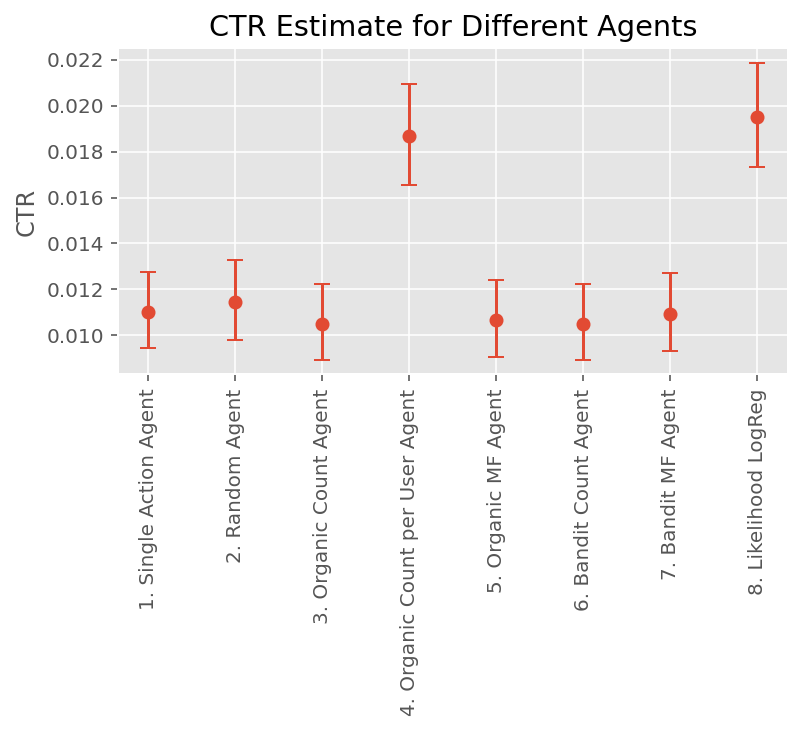

In [12]:
fig = plot_verify_agents(comb_result)
plt.ylabel('CTR')
plt.show()




